In [9]:
from pathlib import Path

from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

from evaluation.eval_analysis import (
    EvalDesc,
    EvalData,
    load_evals,
    find_mutual_proofs,
    PlotPoint,
    count_total_successes,
    get_two_eval_subsets,
    get_three_eval_subets,
)

In [10]:
EVALS = [
    EvalDesc("Proofs + Premises", "deepseek-proof-prem-full-train-500-10min"),
    EvalDesc("Proofs Only", "deepseek-proof-500"),
    EvalDesc("Premises Only", "deepseek-prem-500"),
    EvalDesc("Basic", "deepseek-basic-full-train-500-10min"),
]
RESULTS_LOC = Path("/home/ubuntu/coq-modeling/eval-results")
evals = load_evals(EVALS, RESULTS_LOC)

## Proof Count (Sanity Check)

In [11]:
mutual_proofs = find_mutual_proofs(evals)
print("Mutual proofs:", len(mutual_proofs))

Mutual proofs: 500


## Proofs over Time

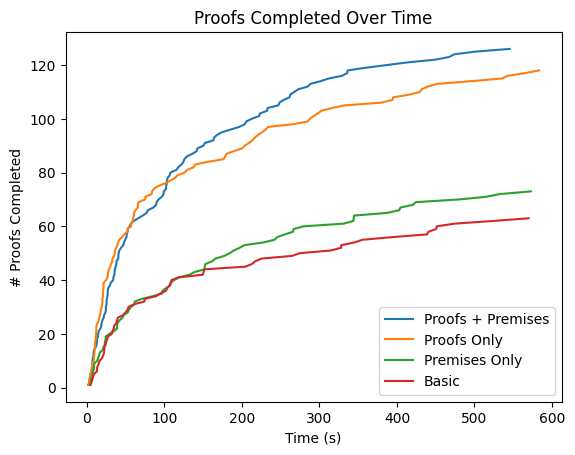

In [12]:
def plot_times(es: list[EvalData]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

## Proofs over Attempts

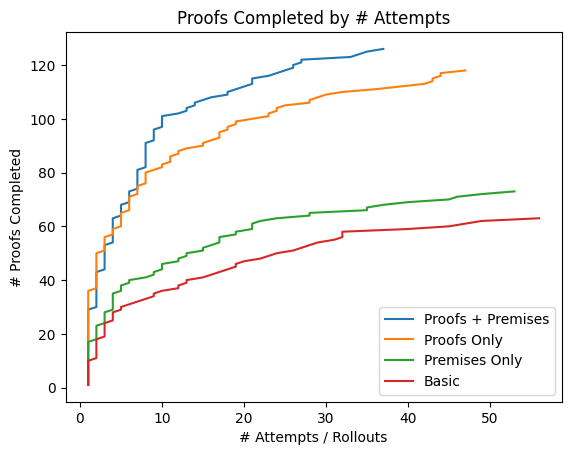

In [13]:
def plot_attempts(es: list[EvalData]):
    attempts = [e.get_attempts_points() for e in es]
    fig, ax = plt.subplots()
    for e, attempt_list in zip(es, attempts):
        xs = [t.x for t in attempt_list]
        ys = [t.y for t in attempt_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("# Attempts / Rollouts")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed by # Attempts")
    ax.legend(loc="lower right")


plot_attempts(evals)

## Overlap Comparison

In [14]:
print("Total # Theorems Found: ", count_total_successes(evals))

Total # Theorems Found:  155


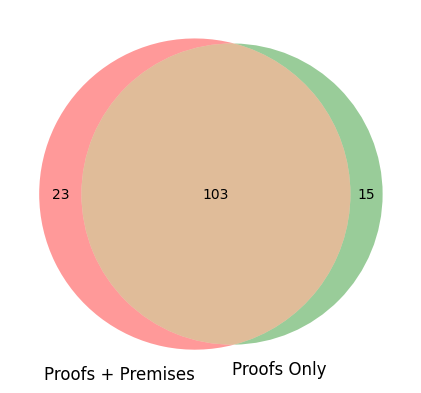

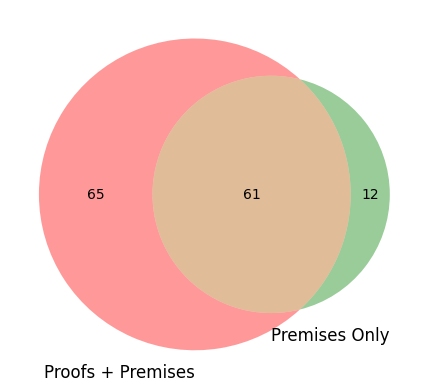

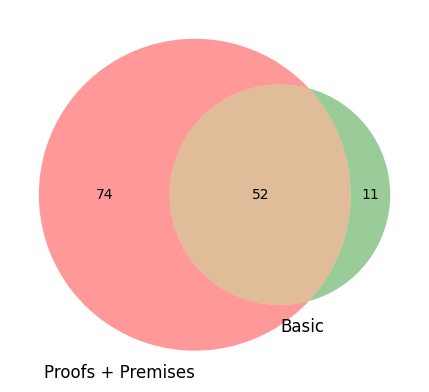

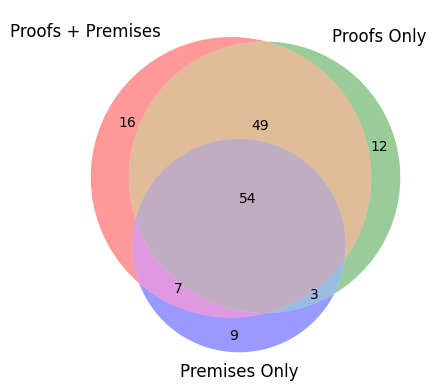

In [17]:
def compare_two(es: list[EvalData], e1_alias: str, e2_alias: str):
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)


def compare_three(es: list[EvalData], e1_alias: str, e2_alias: str, e3_alias: str):
    fig, ax = plt.subplots()
    subsets = get_three_eval_subets(es, e1_alias, e2_alias, e3_alias)
    venn3((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two),
              len(subsets.three_only), len(subsets.one_three), len(subsets.two_three),
              len(subsets.one_two_three)),
             set_labels=(e1_alias, e2_alias, e3_alias), ax=ax)

compare_two(evals, "Proofs + Premises", "Proofs Only")
compare_two(evals, "Proofs + Premises", "Premises Only")
compare_two(evals, "Proofs + Premises", "Basic")
compare_three(evals, "Proofs + Premises", "Proofs Only", "Premises Only")
    